In [180]:
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns
import time
import timeit
from sklearn.datasets import fetch_openml
import pandas as pd
from tempfile import mkdtemp # 3shan a3ml create le temporary file fe al /tmp directory
import os.path as path
from torch.utils.data import Dataset
from libsvmdata import fetch_libsvm
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow



In [155]:
# torch.manual_seed(42)
# torch.cuda.manual_seed(42)

In [156]:
torch_tensor3d = torch.tensor([
                                [
                                [ 1, 2, 3],
                                [ 4, 5, 6],
                                ],
                                [
                                [ 7, 8, 9],
                                [10, 11, 12],
                                ],
                                [
                                [13, 14, 15],
                                [16, 17, 18],
                                ],
                                [
                                [19, 20, 21],
                                [22, 23, 24],
                                ]
                                ])
torch_tensor3d

tensor([[[ 1,  2,  3],
         [ 4,  5,  6]],

        [[ 7,  8,  9],
         [10, 11, 12]],

        [[13, 14, 15],
         [16, 17, 18]],

        [[19, 20, 21],
         [22, 23, 24]]])

## Write a series of for loops that compute the average value in torch_tensor3d

In [157]:
def compute_average(tensor):
    
    sum = 0
    for i in range(tensor.shape[0]):
        for j in range(tensor.shape[1]):
            for k in range(tensor.shape[2]):
                sum += tensor[i, j, k]
    return sum / (tensor.shape[0] * tensor.shape[1] * tensor.shape[2])

print(compute_average(torch_tensor3d))
        

tensor(12.5000)


## Write code that indexes into torch_tensor3d and prints out the value 13

In [158]:
print(torch_tensor3d[2, 0, 0])

tensor(13)


## For every power of 2 (i.e., $2^i$ or $2^i$ ) up to $2^{11}$, create a random matrix X ∈ R2i,2i (i.e., X.shape should give (2**i, 2**i)). Time how long it takes to compute XX (i.e., X@X) on a CPU and on a GPU, and plot the speedup. For what matrix sizes is the CPU faster than the GPU?


In [159]:
gputime = []
cputime = []

for i in range(12):
    
    
    tensorcpu = torch.rand((2**i, 2**i), device='cpu')
    start_time = time.time()
    tensorcpu = tensorcpu@tensorcpu
    end_time = time.time()

    cputime.append(end_time-start_time)

    tensorgpu = torch.rand((2**i, 2**i), device='cuda')
    start_time = time.time()
    tensorgpu = tensorgpu@tensorgpu
    end_time = time.time()
    
    gputime.append(end_time-start_time)


In [160]:
gputime = []
cputime = []
for i in range(12):
    x = torch.rand((2**i, 2**i), device='cuda')
    gputime.append(timeit.timeit('x@x', globals=globals(), number=100))

    x = torch.rand((2**i, 2**i), device='cpu')
    cputime.append(timeit.timeit('x@x', globals=globals(), number=100))


<Axes: >

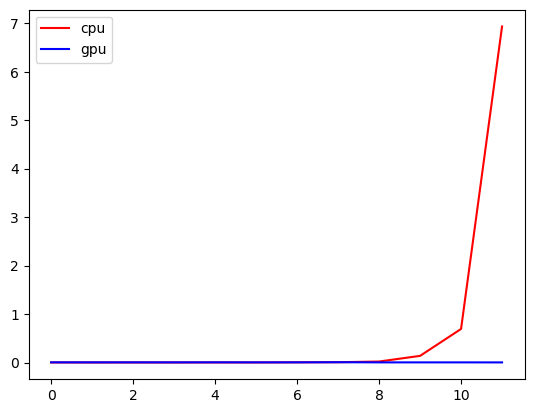

In [161]:
sns.lineplot(x=np.arange(12), y=cputime, label="cpu", color='red') # for cpu // m7tag al x axis w da hykoun mn 0 le 11 w m7tag y w da hykoun al time bta3 koul value
sns.lineplot(x=np.arange(12), y=gputime, label="gpu", color='blue') # for gpu

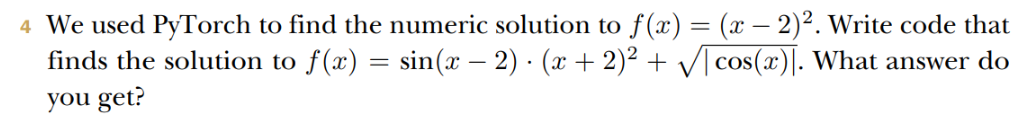

In [162]:
def f(x):
    return torch.sin(x-2) * (x+2)**2 + torch.sqrt(torch.abs(torch.cos(x)))

x = nn.Parameter(torch.rand(1), requires_grad=True)
optimizer = torch.optim.SGD([x], lr=0.05)

print(x.data)
print(f(x))
for epoch in range(60):
    optimizer.zero_grad()
    loss_x = f(x)
    loss_x.backward()
    optimizer.step()

print(x.data)
print(f(x))

tensor([0.5965])
tensor([-5.7382], grad_fn=<AddBackward0>)
tensor([1.0635])
tensor([-6.8625], grad_fn=<AddBackward0>)


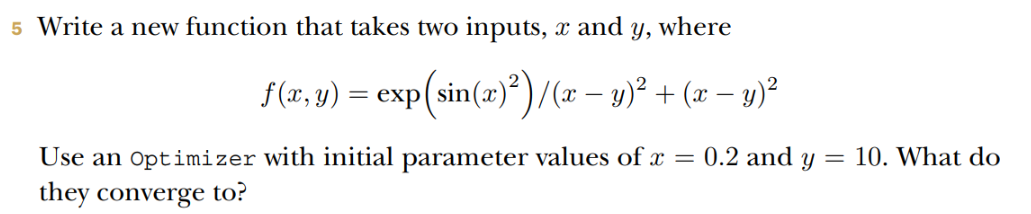

In [163]:
torch.manual_seed(42)
def f(x, y):
    return torch.divide(torch.exp(torch.pow(torch.sin(x), 2)), ((x-y)**2 + (x-y)**2))

x = nn.Parameter(torch.tensor(0.2), requires_grad=True)
y = nn.Parameter(torch.tensor(10.0), requires_grad=True)
optimizer = torch.optim.SGD([x, y], lr=0.05)

for epoch in range(100):
    optimizer.zero_grad()

    loss_xy = f(x, y)
    loss_xy.backward()
    optimizer.step()

print(x.data, y.data)
print(f(x, y))


tensor(0.1844) tensor(10.0055)
tensor(0.0054, grad_fn=<DivBackward0>)


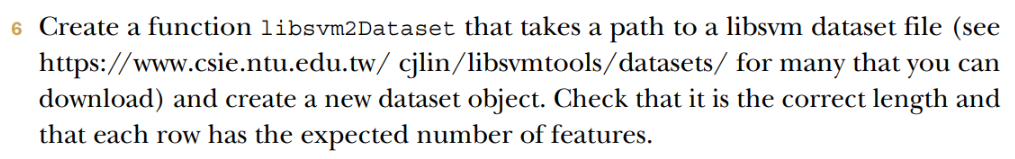

In [164]:


class simpleDataset(Dataset):
    def __init__(self, X, y):
        super(simpleDataset, self).__init__()
        self.X = X
        self.y = y

    def __getitem__(self, index):
        input = torch.tensor(self.X[index, :], dtype=torch.float32)
        target = torch.tensor(self.y[index], dtype=torch.int64)
        

        return input, target
    def __len__(self):
        return self.X.shape[0]

def libsvm2Dataset(Name):
    X, y = fetch_libsvm(Name)
    dataset = simpleDataset(X, y)
    return dataset

dataset = libsvm2Dataset("heart")


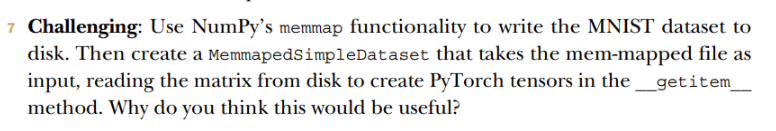

Length:  70000
features:  torch.Size([784])
Label of index 0:  tensor([5])


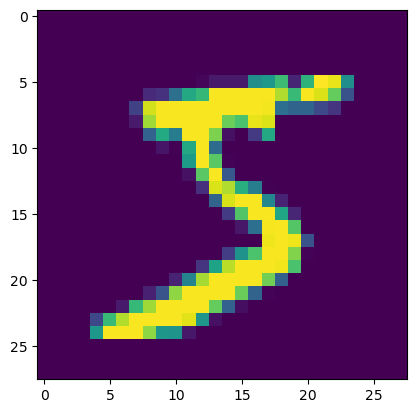

In [181]:
x, y = fetch_openml('mnist_784', version=1, return_X_y=True)

filename = path.join(mkdtemp(), 'mnist.dat')
Xy = pd.concat([x, y], axis=1,  ignore_index=True)
fp = np.memmap(filename, dtype='float32', mode='w+', shape=Xy.shape)
fp[:] = Xy.iloc[:].values
fp.filename = path.abspath(filename)
fp.flush()

class MemmapedSimpleDataset(Dataset):
    def __init__(self, memmappedfile):
        super(MemmapedSimpleDataset, self).__init__()
        self.fmpr = np.memmap(memmappedfile, dtype='float32', mode='r', shape=Xy.shape)
    
    def __getitem__(self, index):
        input = torch.tensor(self.fmpr[index, :-1], dtype=torch.float32)
        target = torch.tensor(self.fmpr[index, -1:], dtype=torch.int64)
        return input, target
    
    def __len__(self):
        return self.fmpr.shape[0]
    
dataset = MemmapedSimpleDataset(filename)
print("Length: ", len(dataset))
example, label = dataset[0]

print("features: ", example.shape)
print("Label of index 0: ", label)

imshow(example.reshape((28, 28)))

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

def train_simple_network(model:torch.nn.Module, 
                        loss_fn: torch.nn, 
                        training_loader: torch.utils.data.DataLoader,
                        epochs: int,
                        device = 'cpu'):
    
    optimizer = torch.optim.SGD(model.parameter(), lr=0.05)
    model.to(device)
    for epoch in tqdm(range(epochs), desc=("Epoch")):
        model.train()
        tot_loss = 0.0

        for inputs, labels in tqdm(training_loader, desc=("Batch")):

            y_pred = model(inputs)

            loss = loss_fn(y_pred, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            tot_loss += loss.item()


TypeError: 'NoneType' object is not iterable